## Paper: Credit Risk Assessment based on Gradient Boosting Decision Tree

## Data Pre-Processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import resample

data_path = "german_credit_data.csv"
data = pd.read_csv(data_path)


In [2]:
data.shape

(1000, 11)

In [3]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1000.0,499.500,288.819436,0.0,249.75,499.5,749.25,999.0
Age,1000.0,35.546,11.375469,19.0,27.00,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.00,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.50,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.00,18.0,24.00,72.0


 Removing redundant column 

In [6]:
data.drop("Unnamed: 0", axis = 1, inplace = True)

### Filling missing values

In [7]:
data.isnull().values.any()
data.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

The dataset comprises 1,000 entries, with 183 entries lacking data in the Savings Account attribute, accounting for 18.3% of the total records. Consequently, we will employ the Most Common Technique to impute these missing values.

In [8]:
savings_mode = data['Saving accounts'].mode()
savings_mode

0    little
Name: Saving accounts, dtype: object

In [9]:
data['Saving accounts'].fillna(savings_mode[0], inplace=True)
data['Saving accounts'].isnull().sum()

0

There are plenty of missing records in the Checking Account attribute, so it would be appropriate to fill in these values rather than remove them to improve the analysis of the data set.

In [10]:
check_mode = data['Checking account'].mode()
check_mode

0    little
Name: Checking account, dtype: object

In [11]:
data['Checking account'].fillna(check_mode[0], inplace=True)
data['Checking account'].isnull().sum()

0

In [12]:
data.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

Target Variable

In [13]:
data["Risk"].value_counts()

Risk
good    700
bad     300
Name: count, dtype: int64

### Encoding


In [14]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders
l_sex = LabelEncoder()
l_risk = LabelEncoder()

# Apply label encoding
data['Sex'] = l_sex.fit_transform(data['Sex'])
data['Risk'] = l_risk.fit_transform(data['Risk'])

# Apply one-hot encoding
data = pd.get_dummies(data, columns=['Housing', 'Saving accounts', 'Checking account', 'Purpose'])
data.head()

,Age,Sex,Job,Credit amount,Duration,Risk,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,1,2,1169,6,1,False,True,False,True,...,False,False,False,False,False,False,False,True,False,False
1,22,0,2,5951,48,0,False,True,False,True,...,True,False,False,False,False,False,False,True,False,False
2,49,1,1,2096,12,1,False,True,False,True,...,False,False,False,False,False,True,False,False,False,False
3,45,1,2,7882,42,1,True,False,False,True,...,False,False,False,False,False,False,True,False,False,False
4,53,1,2,4870,24,0,True,False,False,True,...,False,False,False,True,False,False,False,False,False,False


## Exploratory Data Analysis (EDA)

C:\Users\hamed\AppData\Local\Temp\ipykernel_20428\2633116414.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=data['Risk'], palette='coolwarm')
C:\Users\hamed\AppData\Local\Temp\ipykernel_20428\2633116414.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Low Risk', 'High Risk'])


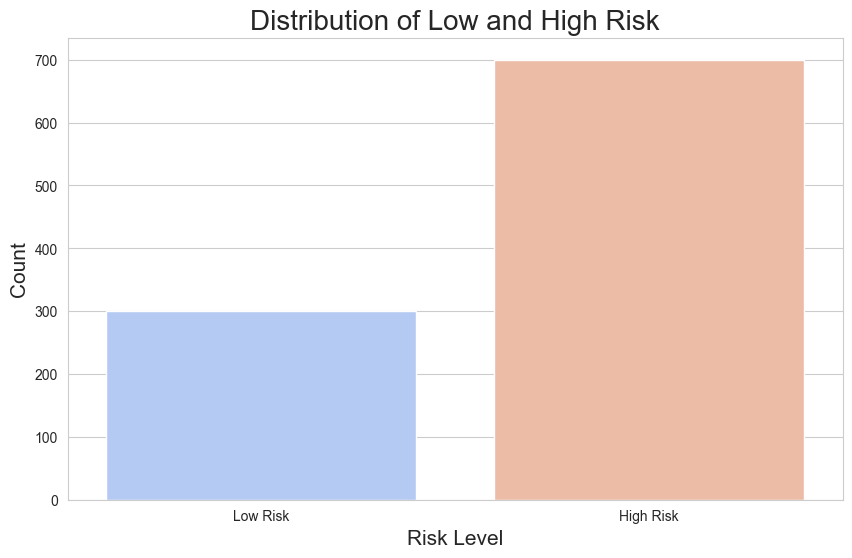

In [15]:

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=data['Risk'], palette='coolwarm')
ax.set_xticklabels(['Low Risk', 'High Risk'])
plt.title('Distribution of Low and High Risk', fontsize=20)
plt.xlabel('Risk Level', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()


The chart labeled "Distribution of Risk" illustrates that instances labeled as "good" risk are significantly more frequent than those labeled as "bad" risk in the dataset, indicating an imbalance. To address this, we must employ suitable methods to balance the data.

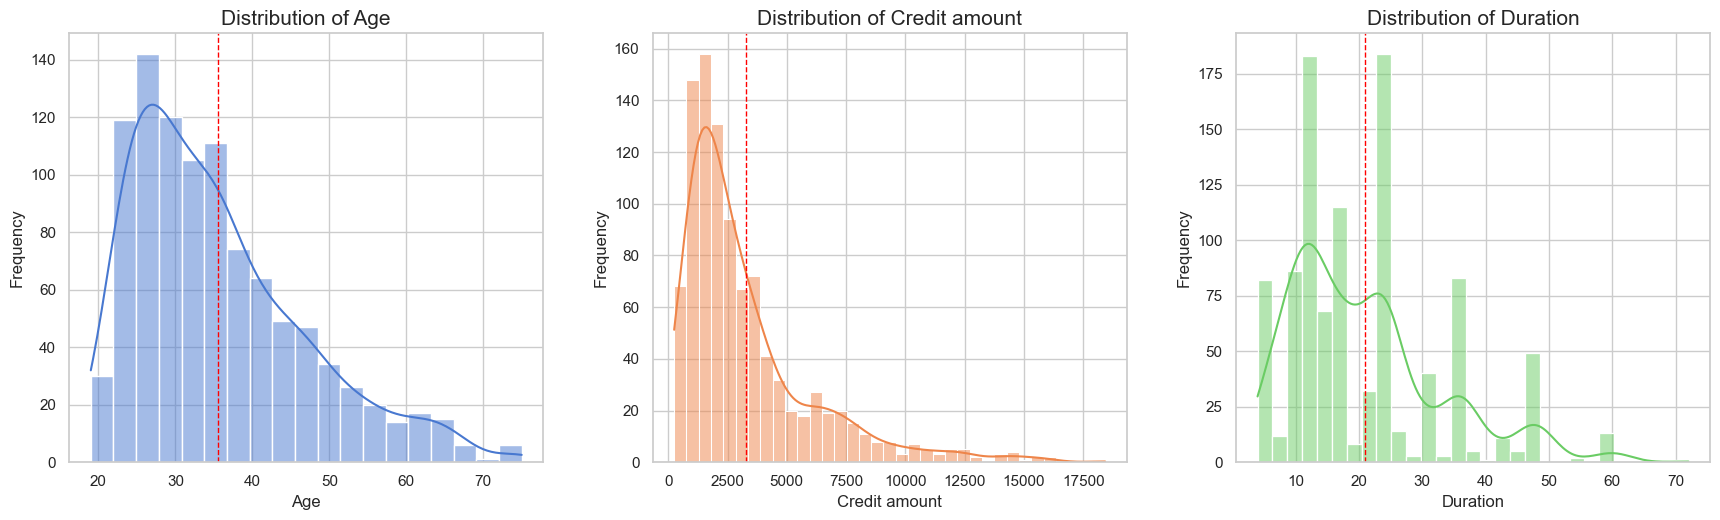

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid", palette="pastel")

# Summary statistics for numerical columns
summary_stats = data.describe()

# Plot distributions for numerical features
numerical_features = ['Age', 'Credit amount', 'Duration']

plt.figure(figsize=(18, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data[feature], kde=True, color=sns.color_palette("muted")[i-1])
    plt.axvline(data[feature].mean(), color='red', linestyle='dashed', linewidth=1)
    plt.title(f'Distribution of {feature}', fontsize=15)
    plt.xlabel(f'{feature}', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

In [17]:
# Calculating Pearson Correlation Coefficients
correlation_matrix = data.corr()
target_correlation = correlation_matrix['Risk'].sort_values(ascending=False) 

print(target_correlation)

Risk                           1.000000
Housing_own                    0.134589
Purpose_radio/TV               0.106922
Age                            0.091127
Checking account_little        0.089895
Saving accounts_rich           0.085749
Sex                            0.075493
Saving accounts_quite rich     0.070954
Checking account_rich          0.044009
Purpose_domestic appliances   -0.008016
Purpose_repairs               -0.020828
Purpose_furniture/equipment   -0.020971
Saving accounts_moderate      -0.022255
Purpose_car                   -0.022621
Purpose_vacation/others       -0.028058
Job                           -0.032735
Purpose_business              -0.036129
Purpose_education             -0.049085
Saving accounts_little        -0.070234
Housing_free                  -0.081556
Housing_rent                  -0.092785
Checking account_moderate     -0.119581
Credit amount                 -0.154739
Duration                      -0.214927
Name: Risk, dtype: float64


Higher risk is positively correlated with owning a house, loans for radio/TV, older age, 
and richer accounts. Lower risk is associated with longer credit durations, larger credit amounts,
 renting/free housing, and loans for education, business, and other purposes.

## Feature Selection and Data Splitting

In [18]:
# Selecting features based on a correlation threshold
threshold = 0.03
selected_features = target_correlation[abs(target_correlation) > threshold].index.tolist()
print("Selected features based on Pearson correlation:", selected_features)

Selected features based on Pearson correlation: ['Risk', 'Housing_own', 'Purpose_radio/TV', 'Age', 'Checking account_little', 'Saving accounts_rich', 'Sex', 'Saving accounts_quite rich', 'Checking account_rich', 'Job', 'Purpose_business', 'Purpose_education', 'Saving accounts_little', 'Housing_free', 'Housing_rent', 'Checking account_moderate', 'Credit amount', 'Duration']


## Splitting data

In [19]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Selected features based on correlation threshold
selected_features = ['Housing_own', 'Housing_own', 'Purpose_radio/TV', 'Age', 'Checking account_little', 'Saving accounts_rich', 
                     'Sex', 'Saving accounts_quite rich', 'Checking account_rich', 'Job', 'Purpose_business', 'Purpose_education', 
                     'Saving accounts_little', 'Housing_free', 'Housing_rent', 'Checking account_moderate', 'Credit amount',
                     'Duration']

# Prepare the data for modeling
X = data[selected_features]
y = data['Risk']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Balancing data

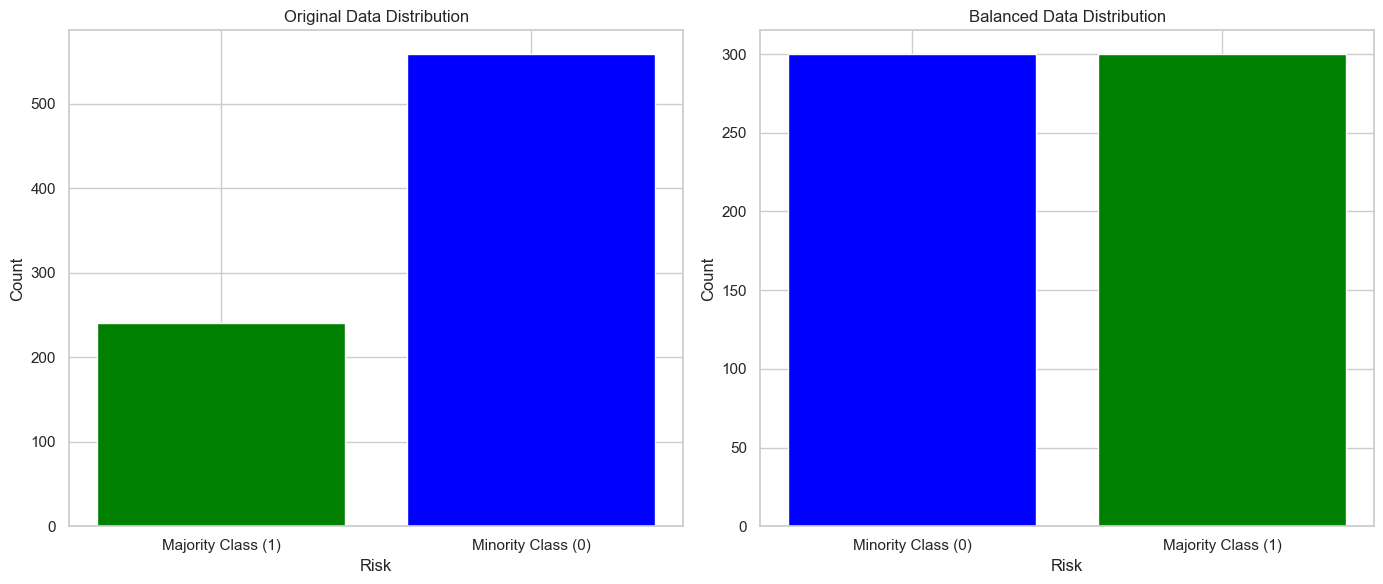

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Assuming X_train, y_train, X_test, and y_test are already defined

# Combining the training data into one DataFrame for easy resampling
train_data = pd.concat([X_train, y_train], axis=1)

majority_class = train_data[train_data['Risk'] == 1]
minority_class = train_data[train_data['Risk'] == 0]

# Ensure each class has 300 samples
desired_samples_per_class = 300

# Undersample the majority class
majority_class_undersampled = resample(majority_class, 
                                       replace=False,    # Sample without replacement
                                       n_samples=desired_samples_per_class,  # Match the desired number of samples per class
                                       random_state=42)  # For reproducibility

# Oversample the minority class if it has fewer samples
minority_class_oversampled = resample(minority_class, 
                                      replace=True,     # Sample with replacement
                                      n_samples=desired_samples_per_class,  # Match the desired number of samples per class
                                      random_state=42)  # For reproducibility

# Combine the undersampled majority class with the oversampled minority class
train_data_balanced = pd.concat([minority_class_oversampled, majority_class_undersampled])

# Separate features and target
X_train_balanced = train_data_balanced.drop('Risk', axis=1)
y_train_balanced = train_data_balanced['Risk']

# Check the distribution of the balanced training data
balanced_distribution = y_train_balanced.value_counts()

# Original distribution
original_distribution = y_train.value_counts()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot original distribution
axes[0].bar(original_distribution.index, original_distribution.values, color=['blue', 'green'])
axes[0].set_title('Original Data Distribution')
axes[0].set_xlabel('Risk')
axes[0].set_ylabel('Count')
axes[0].set_xticks(original_distribution.index)
axes[0].set_xticklabels(['Minority Class (0)', 'Majority Class (1)'])

# Plot balanced distribution
axes[1].bar(balanced_distribution.index, balanced_distribution.values, color=['blue', 'green'])
axes[1].set_title('Balanced Data Distribution')
axes[1].set_xlabel('Risk')
axes[1].set_ylabel('Count')
axes[1].set_xticks(balanced_distribution.index)
axes[1].set_xticklabels(['Minority Class (0)', 'Majority Class (1)'])

plt.tight_layout()
plt.show()


In [21]:
X_train_balanced.to_csv('X_train_balanced.csv', index=False)
y_train_balanced.to_csv('y_train_balanced.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)